In [44]:
import pandas as pd
import numpy as np
import re
import preprocessor as p
import pycld2
import pickle as pkl
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [45]:
# Custom stop word set that does not include any pronouns and any negating words (e.g. don't, wouldn't)
custom_stopwords = {
    "am", "is", "are", "was", "were", "have", "has", "had", "having",
    "do", "does", "did", "doing", "a", "an", "the", "and", "but",
    "if", "or", "because", "as", "until", "while", "of", "at", "by",
    "for", "with", "about", "against", "between", "into", "through",
    "before", "after", "above", "below", "to", "from", "in", "out",
    "on", "over", "under", "again", "then", "once", "when", "where",
    "why", "how", "all", "any", "both", "more", "most", "other",
    "some", "such", "no", "not", "only", "own", "so", "than", "too", "very"
}

In [46]:
def confusion_matrix(y_test, y_pred):

    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["non-cyberbullying", "cyberbullying"])
    plt.yticks(tick_marks, ["non-cyberbullying", "cyberbullying"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.show()


In [47]:
def clean_text(text):

    # This effectively removes all special characters
    text = p.clean(text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
#     words = text.split()

#     # remove leading and trailing white spaces with strip()
#     # remove custom stopwords from text
#     words = [word.strip() for word in words if word.strip() not in custom_stopwords]
#     text = ' '.join(words)

    # Replace multiple consecutive white spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    return text

In [48]:
def preprocess_data(df):

    # Check for missing values
    missing_values = df.isna().sum()
    print(f'Missing Values:\n{missing_values}\n')

    # Find all tweets that are less than 3 words and remove them
    df['tweet_length'] = [len(text.split()) for text in df.tweet_text]
    df = df.loc[df['tweet_length'] >= 3]
    df.drop('tweet_length', axis=1, inplace=True)

    # Clean the text by removing special characters and converting all text to lower case
    df['tweet_text'] = df['tweet_text'].map(clean_text)

    return df

In [49]:
def sample_encode(df):

    df = df.loc[df['tweet_text'].apply(lambda x: safe_detect(x) == 'en')]
    
    # Data balancing 
    # Sample 3,325 observation for each category if stop words are removed
    # Sample 3,450 observation for each category if stop words are not removed
    sample_religion = df.loc[df['cyberbullying_type']=='religion'].sample\
        (n=3450, random_state=42)

    sample_age = df.loc[df['cyberbullying_type']=='age'].sample\
        (n=3450, random_state=42)

    sample_other_cyberbullying = df.loc[df['cyberbullying_type']=='other_cyberbullying'].sample\
        (n=3450, random_state=42)

    sample_ethnicity = df.loc[df['cyberbullying_type']=='ethnicity'].sample\
        (n=3450, random_state=42)

    sample_gender = df.loc[df['cyberbullying_type']=='gender'].sample\
        (n=3450, random_state=42)

    samples_df = pd.concat([sample_religion,sample_age,
                            sample_other_cyberbullying,sample_ethnicity,sample_gender])

    # Manually encode the different types of cyberbullying/non-cyberbullying
    samples_df.loc[:, 'cyberbullying_type'] = 1

    df.loc[df['cyberbullying_type'] == 'not_cyberbullying', 'cyberbullying_type'] = 0
    non_cyberbullying_df = df.loc[df['cyberbullying_type']==0].copy()

    # Ensure target column is of type int
    non_cyberbullying_df['cyberbullying_type'] = non_cyberbullying_df['cyberbullying_type']\
        .astype(int)
    samples_df['cyberbullying_type'] = samples_df['cyberbullying_type'].astype(int)

    df = pd.concat([non_cyberbullying_df,samples_df])

    return df


In [50]:
def load_pkl_data(path):
    with open(path, 'rb') as f:
        data = pkl.load(f)
    return data

In [51]:
def safe_detect(text):
    try:
        return pycld2.detect(text)[2][0][1]
    except Exception:
        return 'unknown'

Check raw formspring_df:                                                 text  label
0  what is your favorite song ? d i like too many...      0
1                                 3 3 ? haha jk ! 33      0
2  hey angel you duh sexy really ? ! ? ! thanks ?...      0
3                                                         0
4                                      meowww rawr ?      0

Missing Values:
tweet_text            0
cyberbullying_type    0
dtype: int64

Check cleaned formspring_df:                                           tweet_text  cyberbullying_type
0  what is your favorite song d i like too many s...                   0
2          hey angel you duh sexy really thanks haha                   0
5  any makeup tips i suck at doing my makeup lol ...                   0
7    are you a morning or night person night shuree                    0
8           are you a trusting person alreadi answrd                   0

Check raw cyberbullying tweet data:                                 

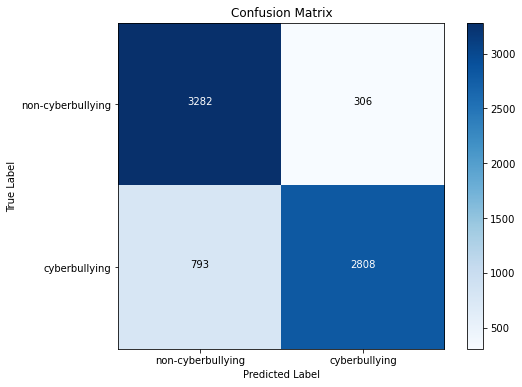

In [52]:
def main():

    data = load_pkl_data('./data 2/formspring_data.pkl')
    formspring_df = pd.DataFrame(data)

    # Check the raw formspring data
    print(f'Check raw formspring_df: {formspring_df.head(5)}\n')
    formspring_df.rename(columns={'text':'tweet_text', 'label':
        'cyberbullying_type'}, inplace=True)
    formspring_df = preprocess_data(formspring_df)

    # Remove any non english entries
    formspring_df = formspring_df.loc[formspring_df['tweet_text'].apply(lambda x: safe_detect(x) == 'en')]

    # Check cleaned formspring data
    print(f'Check cleaned formspring_df: {formspring_df.head(5)}\n')

    df = pd.read_csv("cyberbullying_tweets.csv")

    # Check raw cyberbullying tweet data
    print(f'Check raw cyberbullying tweet data: {df.head(5)}\n')

    df = preprocess_data(df)

    # Check cleaned cyberbullying tweet data
    print(f'Check cleaned cyberbullying tweet data: {df.head(5)}\n')
    df = sample_encode(df)

    # Merge both dataframes for data balancing
    merged_df = pd.concat([df, formspring_df])

    # Check merged dataframe data
    # print(f'Check merged dataframe {merged_df.head(10)}')
    # Check Unique y values
    y_values = merged_df['cyberbullying_type'].value_counts()
    
    for category, count in y_values.items():
        print(f'Y value: {category}, Count: {count}')
    
    print('\n')
    # X is the features (the input data)
    X = merged_df['tweet_text']

    # y is the targets (output or label)
    y = merged_df['cyberbullying_type']

    # Create features based frequency of individual words in a given
    # observation
    
    # recent 84.7 with 2 ngams and no stop words removed 
    # Additional ngrams reduced accuracy 
    # Removing stop words reduced accuracy 
    ngram_vectorizer = CountVectorizer(ngram_range=(1,2))

    X = ngram_vectorizer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y, test_size=0.2,
                                                        random_state=42)

    
    SVM = svm.SVC(kernel='rbf', C=1.0, gamma='scale')
#     SVM = svm.SVC(kernel='linear',decision_function_shape='ovr')

    SVM.fit(X_train, y_train)

    y_pred = SVM.predict(X_test)

    print("Training Complete")
    
    # Calculate and print individual metrics
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    
    # Print confusion matrix
    confusion_matrix(y_test, y_pred)

# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    main()